<a href="https://colab.research.google.com/github/EdwSanA/DPro_Tareas/blob/main/Aprendizajes_por_conjuntos_mejorado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ENSEMBLE LEARNING - BLENDING, BAGGING, STACKING (Ames)
Shape: (1459, 3)
         GrLivArea    YearBuilt      SalePrice
count  1459.000000  1459.000000    1459.000000
mean   1512.635367  1971.242632  180935.535298
std     514.423754    30.197931   79467.851763
min     334.000000  1872.000000   34900.000000
25%    1129.000000  1954.000000  129950.000000
50%    1464.000000  1973.000000  163000.000000
75%    1776.000000  2000.000000  214000.000000
max    4676.000000  2010.000000  755000.000000

Train: (1167, 2),  Val: (292, 2)

=== PROBLEMA 1: BLENDING (3 variantes) ===
Individual 1 - LinearRegression: MSE=1633633845.40 | RMSE=40418.24 | R2=0.7078
Individual 2 - SVR: MSE=4678677788.38 | RMSE=68400.86 | R2=0.1633
Individual 3 - DecisionTreeRegressor: MSE=2004523449.42 | RMSE=44771.90 | R2=0.6415
Blending V1 - Promedio simple: MSE=1707735653.16 | RMSE=41324.76 | R2=0.6946
Blending V2 - Pesos 1/MSE (w=[0.462 0.161 0.377]): MSE=1468172557.89 | RMSE=38316.74 | R2=0.7374
Blending V3 - LR + LR(lo

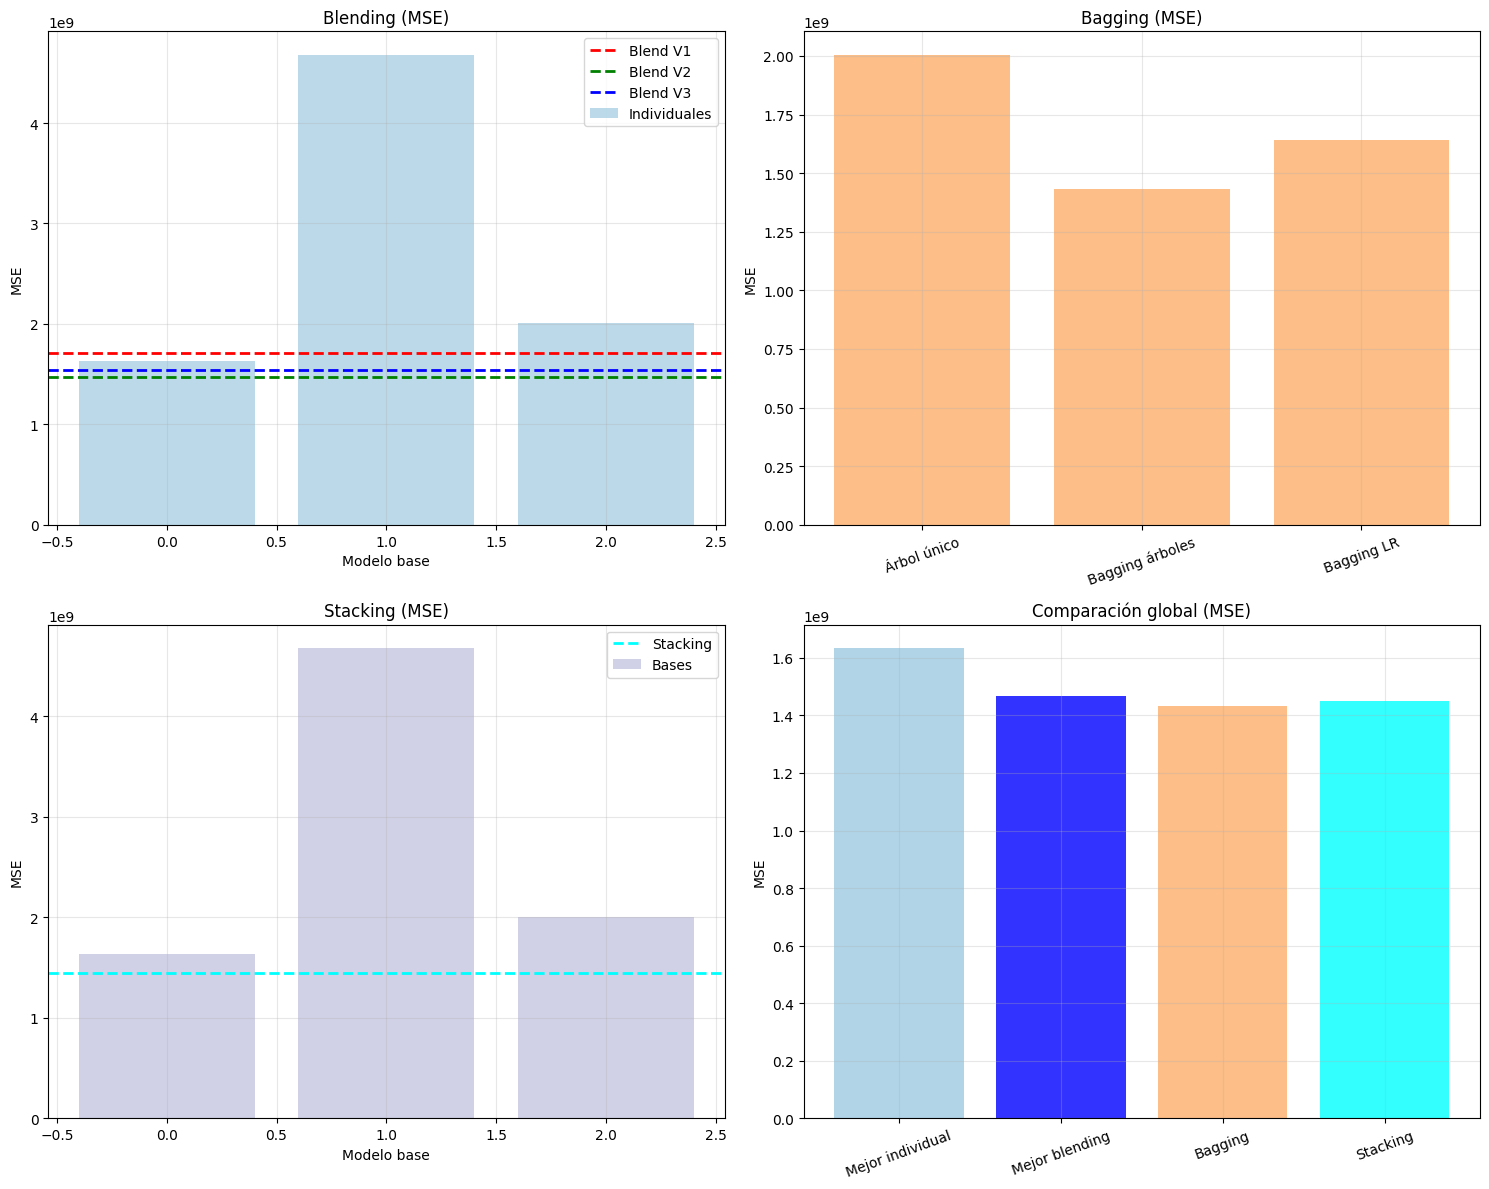


=== RESUMEN FINAL (MSE de validación) ===
Mejor individual (entre modelos de blending): 1633633845.40
Mejor blending: 1468172557.89
Bagging (árboles): 1433554466.39
Stacking: 1448637237.22


In [5]:
# ENSEMBLE LEARNING DESDE CERO (Blending, Bagging, Stacking)
# Dataset: House Prices - train.csv (Ames)
# Variables: SalePrice (y), GrLivArea y YearBuilt (X)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import os

# ------------------------------------------------------------
# 1) Carga y preparación de datos
# ------------------------------------------------------------
def load_housing_data(path="train.csv"):
    """
    Carga el dataset de House Prices (Ames) desde train.csv.
    Usa SOLO: GrLivArea, YearBuilt, SalePrice.
    Si el archivo no existe, genera datos sintéticos para poder ejecutar.
    """
    if os.path.exists(path):
        df = pd.read_csv(path, low_memory=False)
        df = df[['GrLivArea', 'YearBuilt', 'SalePrice']].dropna()
        # Filtro suave para outliers groseros en área
        df = df[(df['GrLivArea'] >= 300) & (df['GrLivArea'] <= 5000)]
        return df

    # ---- Fallback sintético (por si no está train.csv) ----
    rng = np.random.default_rng(42)
    n = 1000
    gr_liv_area = np.clip(rng.normal(1500, 400, n), 800, 3000)
    year_built  = rng.integers(1900, 2020, n)
    noise       = rng.normal(0, 10000, n)
    sale_price  = 50000 + gr_liv_area * 50 + (year_built - 1900) * 200 + noise
    sale_price  = np.clip(sale_price, 50000, 500000)

    df = pd.DataFrame({
        'GrLivArea': gr_liv_area,
        'YearBuilt': year_built,
        'SalePrice': sale_price
    })
    return df

def prepare_data(df):
    """
    Split 80/20 y estandarización de X
    """
    X = df[['GrLivArea', 'YearBuilt']].values
    y = df['SalePrice'].values

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)

    return X_train_scaled, X_val_scaled, y_train, y_val, scaler

def evaluate_model(y_true, y_pred, name):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    print(f"{name}: MSE={mse:.2f} | RMSE={rmse:.2f} | R2={r2:.4f}")
    return {"Model": name, "MSE": mse, "RMSE": rmse, "R2": r2}

# ------------------------------------------------------------
# 2) BLENDING (tres variantes)
# ------------------------------------------------------------
class BlendingRegressor:
    """
    Promedio ponderado de predicciones de modelos base.
    """
    def __init__(self, models, weights=None):
        self.models  = models
        self.weights = (np.array(weights) / np.sum(weights)) if weights is not None else None
        self.is_fitted = False

    def fit(self, X, y):
        for m in self.models:
            m.fit(X, y)
        self.is_fitted = True

    def predict(self, X):
        if not self.is_fitted:
            raise ValueError("Entrena el ensemble antes de predecir.")
        preds = np.column_stack([m.predict(X) for m in self.models])
        if self.weights is None:
            return preds.mean(axis=1)
        return preds @ self.weights

def blending_variants(X_train, y_train, X_val, y_val):
    """
    Prueba 3 mezclas distintas y las compara contra el mejor modelo individual.
    """
    print("\n=== PROBLEMA 1: BLENDING (3 variantes) ===")
    # Modelos diversos (mismos X escalados)
    m1 = LinearRegression()
    m2 = SVR(kernel='rbf', C=100, gamma=0.1)
    m3 = DecisionTreeRegressor(max_depth=10, random_state=42)

    base_models = [m1, m2, m3]
    # Entrenar y evaluar individuales
    individual = []
    for i, m in enumerate(base_models, 1):
        m.fit(X_train, y_train)
        yp = m.predict(X_val)
        individual.append(evaluate_model(y_val, yp, f"Individual {i} - {type(m).__name__}"))
    best_ind_mse = min(individual, key=lambda d: d["MSE"])["MSE"]

    # Guardar predicciones de validación
    P = np.column_stack([m.predict(X_val) for m in base_models])
    mses = np.array([mean_squared_error(y_val, P[:, i]) for i in range(P.shape[1])])

    results = []

    # (V1) Promedio simple
    yb1 = P.mean(axis=1)
    results.append(evaluate_model(y_val, yb1, "Blending V1 - Promedio simple"))

    # (V2) Pesos ~ 1/MSE val
    inv = 1.0 / (mses + 1e-12)
    w = inv / inv.sum()
    yb2 = P @ w
    results.append(evaluate_model(y_val, yb2, f"Blending V2 - Pesos 1/MSE (w={np.round(w,3)})"))

    # (V3) Diversidad de pipeline: entreno LR sobre log1p(y), deslog en val y mezclo 50/50 con LR normal
    lr_lin = LinearRegression().fit(X_train, y_train)
    lr_log = LinearRegression().fit(X_train, np.log1p(y_train))
    y_log_val = np.expm1(lr_log.predict(X_val))
    y_lr_val  = lr_lin.predict(X_val)
    yb3 = 0.5 * y_lr_val + 0.5 * y_log_val
    results.append(evaluate_model(y_val, yb3, "Blending V3 - LR + LR(log) (50/50)"))

    print(f"\nMejor modelo individual (MSE): {best_ind_mse:.2f}")
    mejoras = sum(1 for r in results if r["MSE"] < best_ind_mse)
    print(f"Blends que superan al mejor individual: {mejoras}/3")

    return {"individual": individual, "blends": results, "best_ind_mse": best_ind_mse}

# ------------------------------------------------------------
# 3) BAGGING (bootstraps diversos)
# ------------------------------------------------------------
class BaggingRegressor:
    """
    Bagging desde cero (promedio de modelos entrenados en bootstraps distintos).
    """
    def __init__(self, base_model, n_estimators=20, bootstrap_ratio=0.8, random_state=None):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.bootstrap_ratio = bootstrap_ratio
        self.random_state = random_state
        self.models = []
        self._rng = np.random.default_rng(random_state)
        self.is_fitted = False

    def _bootstrap_sample(self, X, y):
        n = X.shape[0]
        m = int(n * self.bootstrap_ratio)
        idx = self._rng.choice(n, size=m, replace=True)
        return X[idx], y[idx]

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            Xb, yb = self._bootstrap_sample(X, y)
            m = self.base_model.__class__(**self.base_model.get_params())
            m.fit(Xb, yb)
            self.models.append(m)
        self.is_fitted = True

    def predict(self, X):
        if not self.is_fitted:
            raise ValueError("Entrena el bagging antes de predecir.")
        preds = np.column_stack([m.predict(X) for m in self.models])
        return preds.mean(axis=1)

def test_bagging(X_train, y_train, X_val, y_val):
    print("\n=== PROBLEMA 2: BAGGING ===")
    # Modelo único
    tree = DecisionTreeRegressor(max_depth=10, random_state=42).fit(X_train, y_train)
    y_single = tree.predict(X_val)
    single_metrics = evaluate_model(y_val, y_single, "Árbol único (max_depth=10)")
    # Bagging
    bag = BaggingRegressor(
        base_model=DecisionTreeRegressor(max_depth=10, random_state=42),
        n_estimators=30, bootstrap_ratio=0.8, random_state=42
    )
    bag.fit(X_train, y_train)
    y_bag = bag.predict(X_val)
    bag_metrics = evaluate_model(y_val, y_bag, "Bagging (30 árboles)")
    # Bagging con base lineal (comparativo)
    bag_lr = BaggingRegressor(
        base_model=LinearRegression(),
        n_estimators=20, bootstrap_ratio=0.8, random_state=42
    )
    bag_lr.fit(X_train, y_train)
    y_bag_lr = bag_lr.predict(X_val)
    bag_lr_metrics = evaluate_model(y_val, y_bag_lr, "Bagging (20 regresores lineales)")

    return {"single_tree": single_metrics, "bag_tree": bag_metrics, "bag_lr": bag_lr_metrics}

# ------------------------------------------------------------
# 4) STACKING (OOF + meta-modelo)
# ------------------------------------------------------------
class StackingRegressor:
    """
    Stacking desde cero: genera predicciones OOF de modelos base y entrena meta-modelo.
    """
    def __init__(self, base_models, meta_model, n_folds=3, random_state=42):
        self.base_models = base_models
        self.meta_model  = meta_model
        self.n_folds = n_folds
        self.random_state = random_state
        self.trained_bases = []
        self.trained_meta  = None
        self.is_fitted = False

    def _create_oof_features(self, X, y):
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof = np.zeros((X.shape[0], len(self.base_models)))
        for tr, va in kf.split(X):
            Xtr, Xva = X[tr], X[va]; ytr = y[tr]
            for j, base in enumerate(self.base_models):
                mb = base.__class__(**base.get_params())
                mb.fit(Xtr, ytr)
                oof[va, j] = mb.predict(Xva)
        return oof

    def fit(self, X, y):
        # OOF para meta-modelo
        Z = self._create_oof_features(X, y)
        self.trained_meta = self.meta_model.__class__(**self.meta_model.get_params())
        self.trained_meta.fit(Z, y)
        # Reentrenar bases en todo el train
        self.trained_bases = []
        for base in self.base_models:
            mb = base.__class__(**base.get_params())
            mb.fit(X, y)
            self.trained_bases.append(mb)
        self.is_fitted = True

    def predict(self, X):
        if not self.is_fitted:
            raise ValueError("Entrena el stacking antes de predecir.")
        Ztest = np.column_stack([m.predict(X) for m in self.trained_bases])
        return self.trained_meta.predict(Ztest)

def test_stacking(X_train, y_train, X_val, y_val):
    print("\n=== PROBLEMA 3: STACKING ===")
    bases = [
        LinearRegression(),
        SVR(kernel='rbf', C=100, gamma=0.1),
        DecisionTreeRegressor(max_depth=10, random_state=42)
    ]
    meta = LinearRegression()

    # Individuales
    indiv = []
    for i, m in enumerate(bases, 1):
        m.fit(X_train, y_train)
        ypi = m.predict(X_val)
        indiv.append(evaluate_model(y_val, ypi, f"Base {i} - {type(m).__name__}"))

    # Stacking
    stack = StackingRegressor(bases, meta, n_folds=3, random_state=42)
    stack.fit(X_train, y_train)
    yps = stack.predict(X_val)
    stack_metrics = evaluate_model(y_val, yps, "Stacking (LR meta)")

    return {"individual": indiv, "stacking": stack_metrics}

# ------------------------------------------------------------
# 5) Visualización (líneas de referencia con colores distintos)
# ------------------------------------------------------------
def visualize_results(results_dict):
    """
    Visualiza los resultados con colores diferenciados en líneas de referencia:
    - Blend V1 rojo, V2 verde, V3 azul
    - Stacking cian
    """
    print("=== VISUALIZATION OF RESULTS ===\n")

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # ----- Blending -----
    if 'blending' in results_dict:
        blending_results = results_dict['blending']
        individual_mses = [r['MSE'] for r in blending_results['individual']]
        blend_mses = [r['MSE'] for r in blending_results['blends']]

        axes[0, 0].bar(range(len(individual_mses)), individual_mses,
                       alpha=0.7, label="Individuales", color="#9ecae1")

        # Colores distintos para cada variante de blend
        colors = ['red', 'green', 'blue']
        labels = ['Blend V1', 'Blend V2', 'Blend V3']
        for i, mse in enumerate(blend_mses):
            axes[0, 0].axhline(y=mse, color=colors[i], linestyle='--', linewidth=2, label=labels[i])

        axes[0, 0].set_title("Blending (MSE)")
        axes[0, 0].set_xlabel("Modelo base")
        axes[0, 0].set_ylabel("MSE")
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

    # ----- Bagging -----
    if 'bagging' in results_dict:
        bagging_results = results_dict['bagging']
        models = ['Árbol único', 'Bagging árboles', 'Bagging LR']
        mses = [bagging_results['single_tree']['MSE'],
                bagging_results['bag_tree']['MSE'],
                bagging_results['bag_lr']['MSE']]

        axes[0, 1].bar(models, mses, alpha=0.8, color='#fdae6b')
        axes[0, 1].set_title("Bagging (MSE)")
        axes[0, 1].set_ylabel("MSE")
        axes[0, 1].tick_params(axis='x', rotation=20)
        axes[0, 1].grid(True, alpha=0.3)

    # ----- Stacking -----
    if 'stacking' in results_dict:
        stacking_results = results_dict['stacking']
        individual_mses = [r['MSE'] for r in stacking_results['individual']]
        stacking_mse = stacking_results['stacking']['MSE']

        axes[1, 0].bar(range(len(individual_mses)), individual_mses,
                       alpha=0.7, label="Bases", color="#bcbddc")
        axes[1, 0].axhline(y=stacking_mse, color='cyan', linestyle='--', linewidth=2, label="Stacking")
        axes[1, 0].set_title("Stacking (MSE)")
        axes[1, 0].set_xlabel("Modelo base")
        axes[1, 0].set_ylabel("MSE")
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # ----- Comparación global -----
    if all(key in results_dict for key in ['blending', 'bagging', 'stacking']):
        methods = ['Mejor individual', 'Mejor blending', 'Bagging', 'Stacking']
        best_individual = min(results_dict['blending']['individual'], key=lambda x: x['MSE'])['MSE']
        best_blend = min(results_dict['blending']['blends'], key=lambda x: x['MSE'])['MSE']
        best_bagging = results_dict['bagging']['bag_tree']['MSE']
        best_stacking = results_dict['stacking']['stacking']['MSE']
        best_mses = [best_individual, best_blend, best_bagging, best_stacking]

        axes[1, 1].bar(methods, best_mses,
                       alpha=0.8, color=['#9ecae1', 'blue', '#fdae6b', 'cyan'])
        axes[1, 1].set_title("Comparación global (MSE)")
        axes[1, 1].set_ylabel("MSE")
        axes[1, 1].tick_params(axis='x', rotation=20)
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 6) MAIN
# ------------------------------------------------------------
def main():
    print("ENSEMBLE LEARNING - BLENDING, BAGGING, STACKING (Ames)")
    print("="*60)

    # Cargar y mostrar dataset
    df = load_housing_data("train.csv")
    print("Shape:", df.shape)
    print(df.describe()[['GrLivArea','YearBuilt','SalePrice']])

    # Train/Val 80/20 + escalado
    X_train, X_val, y_train, y_val, scaler = prepare_data(df)
    print(f"\nTrain: {X_train.shape},  Val: {X_val.shape}")

    # Blending (3 variantes + comparación)
    blend_res = blending_variants(X_train, y_train, X_val, y_val)

    # Bagging (diversidad real)
    bag_res = test_bagging(X_train, y_train, X_val, y_val)

    # Stacking (OOF + retrain)
    stack_res = test_stacking(X_train, y_train, X_val, y_val)

    # Visualización
    results = {"blending": blend_res, "bagging": bag_res, "stacking": stack_res}
    visualize_results(results)

    # Resumen rápido
    print("\n=== RESUMEN FINAL (MSE de validación) ===")
    best_ind_blend = min(blend_res["individual"], key=lambda d: d["MSE"])["MSE"]
    best_blend     = min(blend_res["blends"], key=lambda d: d["MSE"])["MSE"]
    print(f"Mejor individual (entre modelos de blending): {best_ind_blend:.2f}")
    print(f"Mejor blending: {best_blend:.2f}")
    print(f"Bagging (árboles): {bag_res['bag_tree']['MSE']:.2f}")
    print(f"Stacking: {stack_res['stacking']['MSE']:.2f}")

if __name__ == "__main__":
    main()

